In [2]:
from pipeline import *
from utils import *

## 1. Read raw datacube and remove background & fringe

In [2]:
raw_datacube = read_raw_SITELLE_datacube("/home/qliu/data/A2390C4new.fits",name="A2390C")
raw_datacube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2064                                                  
NAXIS3  =                  124                                                  
EXTEND  =                    T                                                  
DATE    = '2017-09-29'         / Creation date                                  
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectrum Cube' / Type of file                             
OBSERVAT= 'CFHT    '           / Observatory name                               
TELESCOP= 'CFHT 3.6m'          / Hawaii Big Island, Mauna Kea                   
INSTRUME= 'SITELLE '        

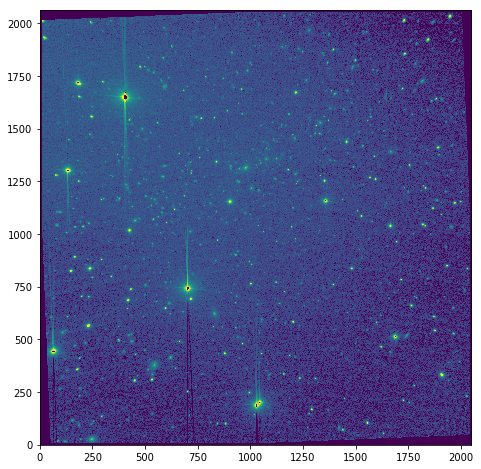

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.raw_stack_field, norm=norm1, origin="lower", vmin=6, vmax=100)

In [16]:
raw_datacube.save_mask_edge(save_path = './proc/')

In [4]:
raw_datacube.remove_background(box_size=128, save_path='./A2390C/fig/bkg/128/', plot=False)

Removing background... Channel: 10
Removing background... Channel: 20
Removing background... Channel: 30
Removing background... Channel: 40
Removing background... Channel: 50


In [6]:
raw_datacube.remove_fringe(channels=[1,2,3,4,5,51,52], save_path='./A2390C/fig/bkg/128/', plot=True)

Removing fringe... Channel: 1
Removing fringe... Channel: 2
Removing fringe... Channel: 3
Removing fringe... Channel: 4
Removing fringe... Channel: 5
Removing fringe... Channel: 51
Removing fringe... Channel: 52


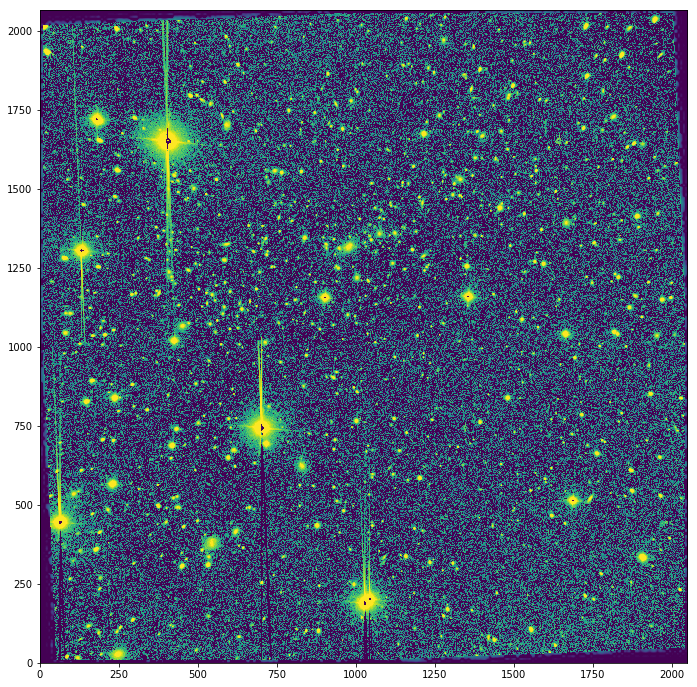

In [76]:
plt.figure(figsize=(12,12))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

In [ ]:
raw_datacube.save_weight_map(region_path="./A2390C/A2390C_mask.reg", weight=0.001, save_path = './proc/')

In [9]:
raw_datacube.save_fits(save_path = './proc/', suffix="")

Saving background & fringe subtracted datacube and stacked field...


## 2. Extract source and spectra from datacube 

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', name='A2390C', mode="MMA")

In [3]:
src_map, segm, segmap = datacube.ISO_source_detection(sn_thre=2, nlevels=64, contrast=0.01, closing=True,
                                                       save=True, save_path = './proc/', suffix="")

Use the map of maximum of moving average (MMA) along wavelength to detect source.
Detecting and deblending source...


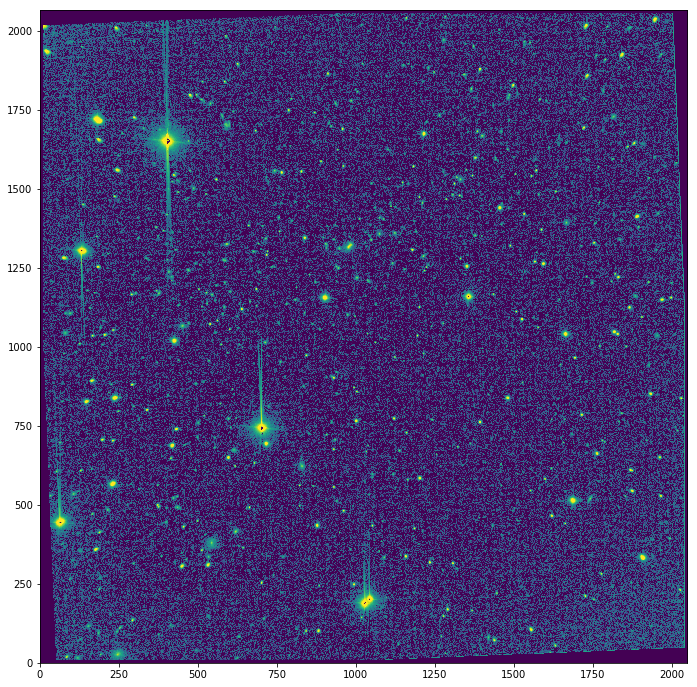

In [29]:
plt.figure(figsize=(12,12))
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

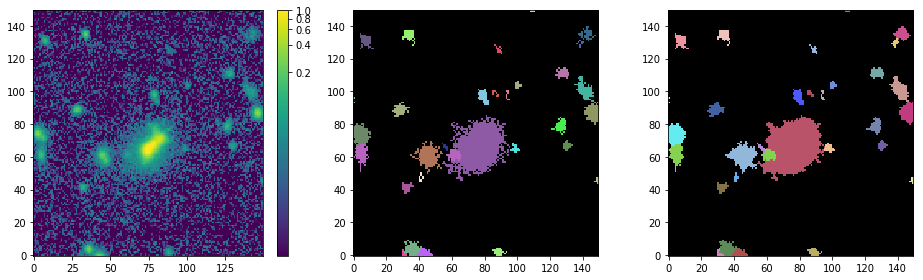

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
im1 = ax1.imshow(src_map[1250:1400,900:1050], norm=norm1, aspect="auto",origin="lower", vmin=np.median(src_map), vmax=1)
colorbar(im1)   
im2 = ax2.imshow(segm.data[1250:1400,900:1050], origin="lower", cmap=segm.make_cmap())
im3 = ax3.imshow(segmap[1250:1400,900:1050], origin="lower", cmap=segm.make_cmap()) 
plt.tight_layout()

In [8]:
datacube.ISO_spec_extraction_all(segmap)

Extract spectra... 400/1986
Extract spectra... 800/1986
Extract spectra... 1200/1986
Extract spectra... 1600/1986


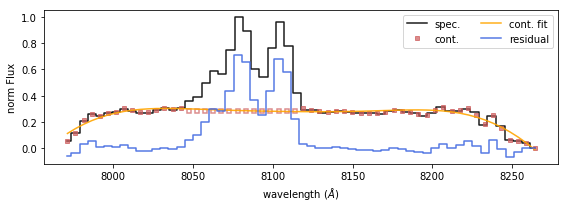

In [16]:
res, wavl_rebin, cont_fit = fit_continuum(datacube.obj_specs_opt[1887], datacube.wavl, edge_ratio=0.15)

In [17]:
datacube.fit_continuum_all(model='GP', plot=True, save_path='./A2390C/fig_iso/fit_cont_MMA/')

./A2390C/fig_m2iso/fit_cont_MMA/ does not exist. Make a new directory.
Fit continuum with GP. No edge_ratio is given. Use estimate = 0.08
Spurious detection #1 ... Skip
Spurious detection #2 ... Skip
Spurious detection #14 ... Skip
Spurious detection #17 ... Skip
Spurious detection #21 ... Skip
Spurious detection #22 ... Skip
Spurious detection #23 ... Skip
Spurious detection #26 ... Skip
Spurious detection #27 ... Skip
Spurious detection #28 ... Skip
Spurious detection #29 ... Skip
Spurious detection #30 ... Skip
Spurious detection #31 ... Skip
Fit spectra continuum ... 200/1986
Fit spectra continuum ... 400/1986
Fit spectra continuum ... 600/1986
Fit spectra continuum ... 800/1986
Fit spectra continuum ... 1000/1986
Fit spectra continuum ... 1200/1986
Fit spectra continuum ... 1400/1986
Fit spectra continuum ... 1600/1986
Spurious detection #1713 ... Skip
Spurious detection #1714 ... Skip
Spurious detection #1715 ... Skip
Spurious detection #1716 ... Skip
Spurious detection #1717 ...

In [18]:
datacube.save_spec_fits(save_path='./proc/', suffix="_all")

### Comparison

In [19]:
hdu_spec = fits.open('./A2390C/A2390C-spec_v4.fits')
obj_nums = hdu_spec[0].data
obj_specs_opt = hdu_spec[3].data
wavl_rebin = hdu_spec[6].data

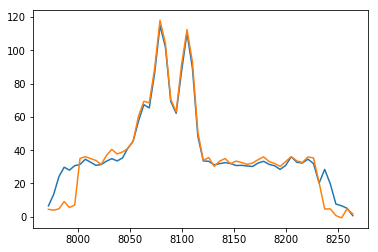

In [20]:
plt.plot(datacube.wavl, datacube.obj_specs_opt[1887])
plt.plot(datacube.wavl, obj_specs_opt[1935])

## Generate Templates

In [1]:
from pipeline import *
from utils import *

In [3]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', 
                         name='A2390C', z0=0.228, mode="MMA",
                         table='./proc/A2390C_MMA.dat', 
                         seg_map='./proc/A2390C_segm_MMA.fits')

In [4]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2, 
                           temp_type="OII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.), 
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8),
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='gauss')

Template: OII_gauss  Total Number: 10
Template: Hb-OIII_gauss  Total Number: 80
Template: Ha-NII_gauss  Total Number: 400


Template: Ha-NII_box  Total Number: 40


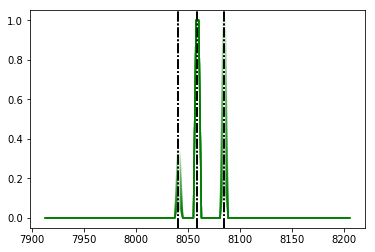

In [5]:
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), temp_params={'box_width':3},
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box', plot=True)

In [6]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2,
                           temp_type="OII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.),
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), 
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box')

Template: OII_box  Total Number: 1
Template: Hb-OIII_box  Total Number: 8
Template: Ha-NII_box  Total Number: 40


In [7]:
for mod in ['gauss','box']:
    for typ in ["Ha-NII", "Hb-OIII", "OII"]:
        datacube.Save_Template(save_path='./proc/temp/', temp_type=typ, temp_model=mod)

Save A2390C templates for Ha-NII_gauss
Save A2390C templates for Hb-OIII_gauss
Save A2390C templates for OII_gauss
Save A2390C templates for Ha-NII_box
Save A2390C templates for Hb-OIII_box
Save A2390C templates for OII_box


## Cross-correlation

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2390C_cube.fits', 
                         name='A2390C', z0=0.228, mode="MMA",
                         table='./proc/A2390C_MMA.dat', 
                         seg_map='./proc/A2390C_segm_MMA.fits')

In [8]:
datacube.read_spec('./proc/A2390C-spec-MMA_all.fits')

In [9]:
datacube.Read_Template('./proc/temp/', n_intp=2)

Read Emission Line Template:
['./proc/temp/Template-A2390C_Ha-NII_gauss.fits',
 './proc/temp/Template-A2390C_Hb-OIII_gauss.fits',
 './proc/temp/Template-A2390C_OII_gauss.fits',
 './proc/temp/Template-A2390C_Ha-NII_box.fits',
 './proc/temp/Template-A2390C_Hb-OIII_box.fits',
 './proc/temp/Template-A2390C_OII_box.fits']


Best z: 0.23097767795382668 Best sigma: 5.813326221342571
Peak wavl 8078.020247799565
Detection #1888  z: 0.231  Peak R: 1.570  Detction S/N: 91.287 Peak S/N: 7.888


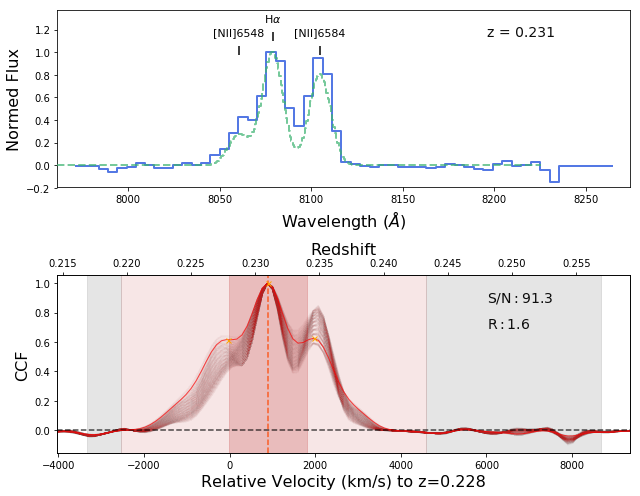

In [10]:
result = datacube.cross_correlation(1888, temp_type="Ha-NII", edge=15, temp_model="gauss")

Best z: 0.23097767795382668 Best sigma: 2.219596146042938
Peak wavl 8078.020247799565
Detection #1888  z: 0.231  Peak R: 1.705  Detction S/N: 52.798 Peak S/N: 5.741


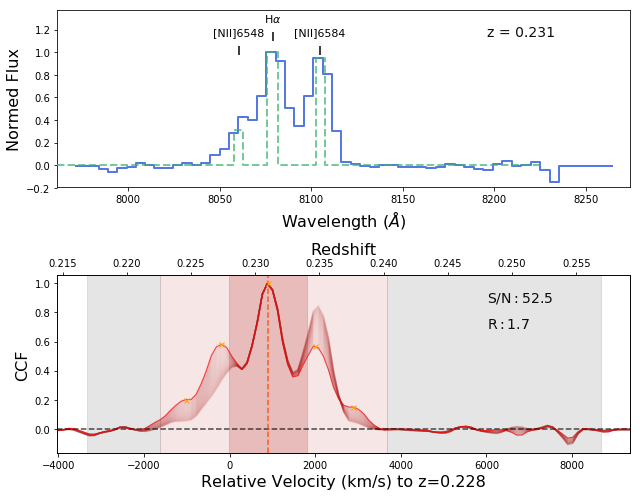

In [11]:
result = datacube.cross_correlation(1888, temp_type="Ha-NII", edge=15, temp_model="box")

Best z: 0.6347143205130001 Best sigma: 3.0182028294428562
Peak wavl 8186.064412722317
Detection #11  z: 0.635  Peak R: 3.475  Detction S/N: 10.697 Peak S/N: 10.697


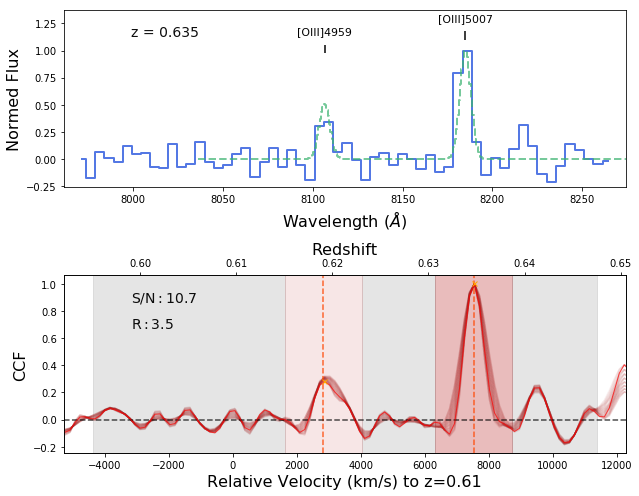

In [18]:
result = datacube.cross_correlation(11, temp_type="Hb-OIII", edge=15, temp_model="gauss")

Best z: 1.201376691832531 Best sigma: 2.219596146042938
Peak wavl 8201.616812689024
Detection #4  z: 1.201  Peak R: 1.000  Detction S/N: 23.069 Peak S/N: 23.069


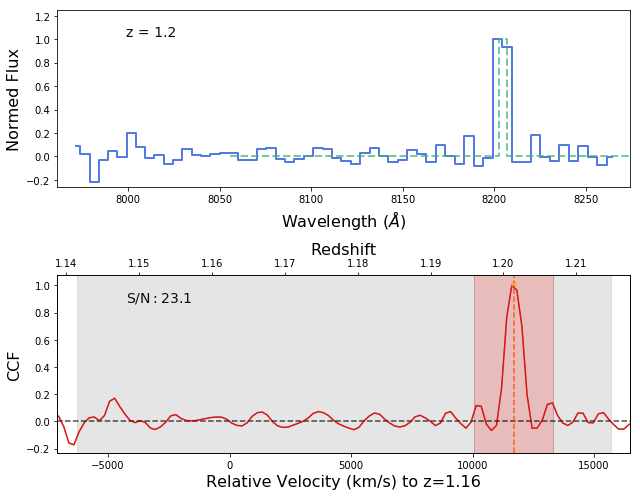

In [14]:
result = datacube.cross_correlation(4, temp_type="OII", edge=10, temp_model="box")

Best z: 0.23880011542637194 Best sigma: 2.618899487742897
Peak wavl 8129.290836512926
Detection #1333  z: 0.239  Peak R: 3.025  Detction S/N: 46.347 Peak S/N: 13.041


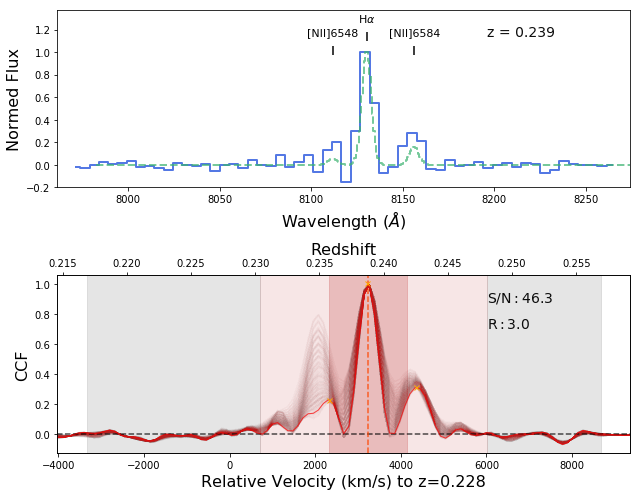

In [16]:
result = datacube.cross_correlation(1333, temp_type="Ha-NII", edge=15, temp_model="gauss")

Best z: 0.23874651408633843 Best sigma: 2.219596146042938
Peak wavl 8129.290836512926
Detection #1333  z: 0.239  Peak R: 3.476  Detction S/N: 43.065 Peak S/N: 14.390


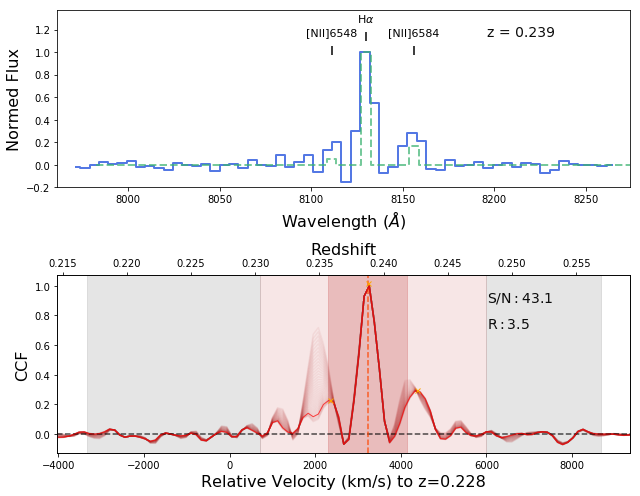

In [15]:
result = datacube.cross_correlation(1333, temp_type="Ha-NII", edge=15, temp_model="box")